# **Setting up the environment**

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# **Data-split**

In [3]:
import tensorflow_datasets as tfds 
train_set, valid_set, test_set = tfds.load(
    name="imdb_reviews",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteM2S5AY/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteM2S5AY/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteM2S5AY/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


# **Shuffling and prefetching**

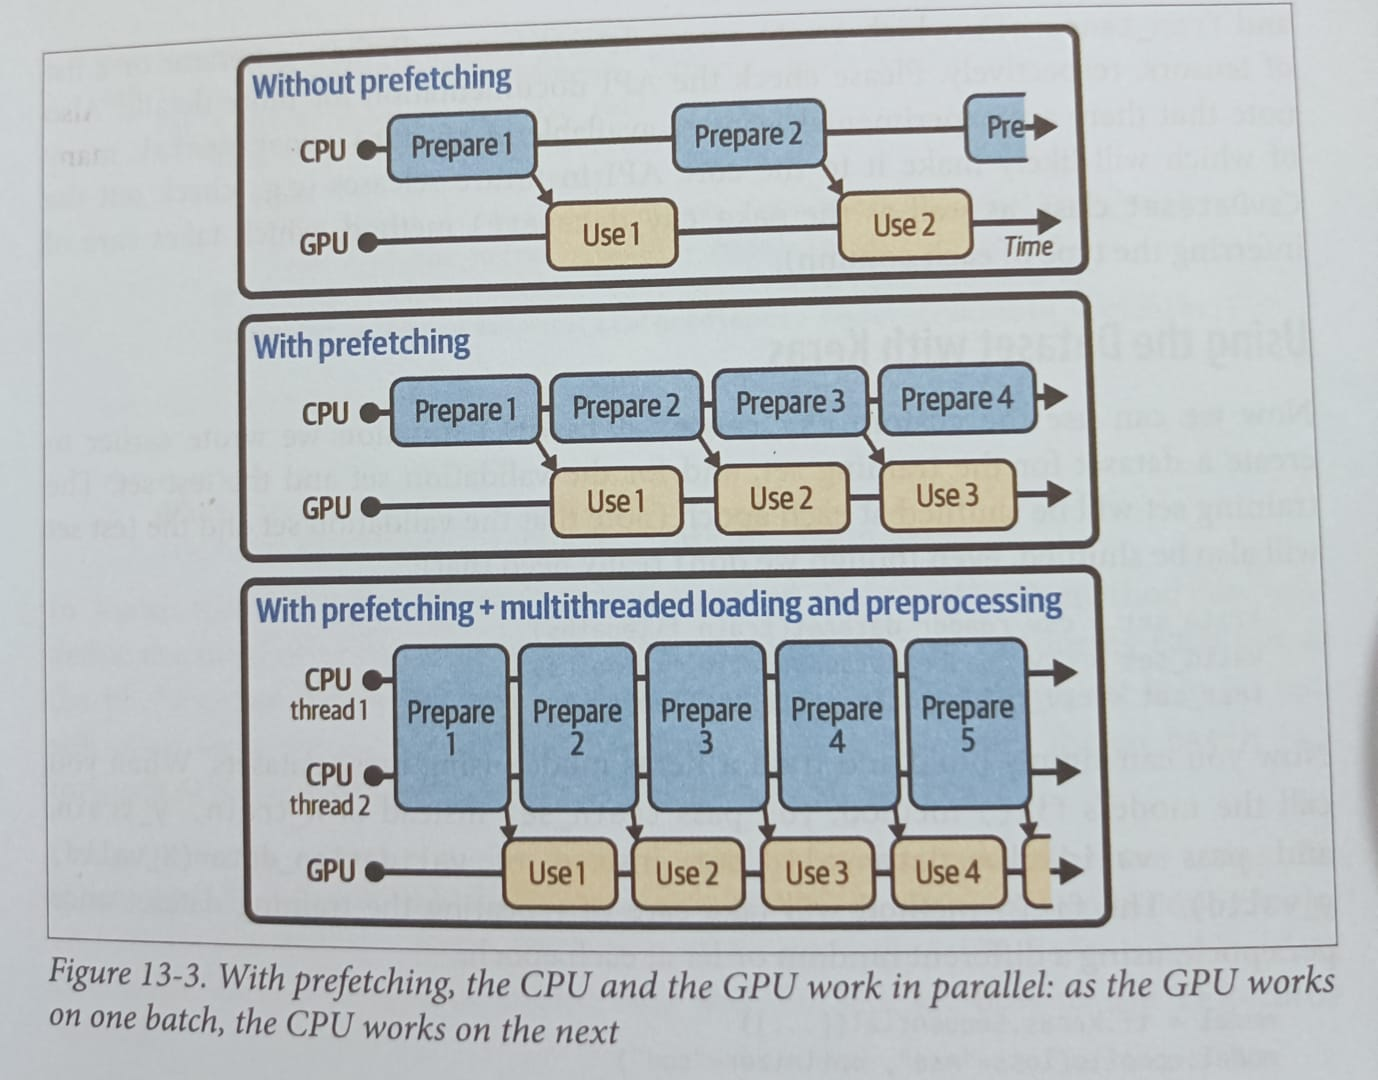

In [4]:
train_set = train_set.shuffle(10_000, seed=42).batch(32).prefetch(1)
valid_set = valid_set.batch(32).cache()
test_set = test_set.batch(32).cache()

# **Text vectorization (TF-IDF)**

In [5]:
max_tokens = 1000
sample_reviews = train_set.map(lambda review, label: review)
text_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens, output_mode="tf_idf")
text_vectorization.adapt(sample_reviews)

In [6]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vectorization,
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, epochs=8, validation_data=valid_set)

Epoch 1/8
704/704 [==============================] - 15s 9ms/step - loss: 0.4178 - accuracy: 0.8174 - val_loss: 0.3497 - val_accuracy: 0.8520
Epoch 2/8
704/704 [==============================] - 7s 9ms/step - loss: 0.3329 - accuracy: 0.8630 - val_loss: 0.3622 - val_accuracy: 0.8452
Epoch 3/8
704/704 [==============================] - 6s 8ms/step - loss: 0.2898 - accuracy: 0.8751 - val_loss: 0.3606 - val_accuracy: 0.8464
Epoch 4/8
704/704 [==============================] - 7s 9ms/step - loss: 0.2386 - accuracy: 0.8982 - val_loss: 0.4077 - val_accuracy: 0.8380
Epoch 5/8
704/704 [==============================] - 6s 8ms/step - loss: 0.1797 - accuracy: 0.9253 - val_loss: 0.4184 - val_accuracy: 0.8448
Epoch 6/8
704/704 [==============================] - 6s 8ms/step - loss: 0.1335 - accuracy: 0.9477 - val_loss: 0.5407 - val_accuracy: 0.8424
Epoch 7/8
704/704 [==============================] - 7s 9ms/step - loss: 0.0937 - accuracy: 0.9640 - val_loss: 0.5884 - val_accuracy: 0.8376
Epoch 8/8
70

In [7]:
model.evaluate(test_set)

782/782 [==============================] - 6s 8ms/step - loss: 0.7573 - accuracy: 0.8351


[0.757300078868866, 0.8351200222969055]

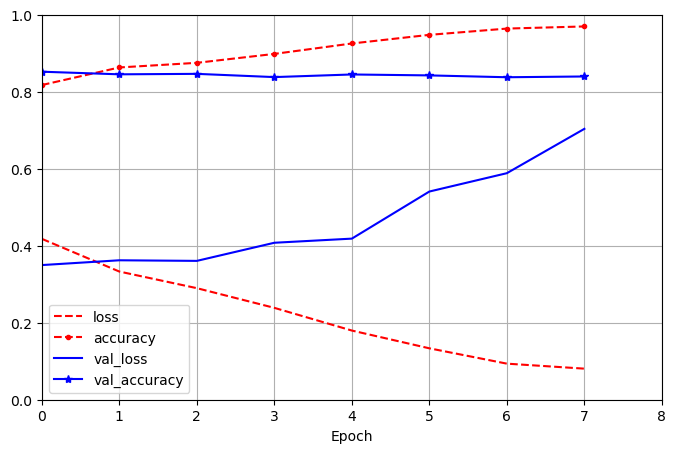

In [8]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 8], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")
plt.show()

# **Embedding with text vectorization**

In [9]:
def compute_mean_embedding(inputs):
    not_pad = tf.math.count_nonzero(inputs, axis=-1)
    n_words = tf.math.count_nonzero(not_pad, axis=-1, keepdims=True)    
    sqrt_n_words = tf.math.sqrt(tf.cast(n_words, tf.float32))
    return tf.reduce_sum(inputs, axis=1) / sqrt_n_words

embedding_size = 20

In [10]:
text_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens, output_mode="int")
text_vectorization.adapt(sample_reviews)

In [11]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vectorization,
    tf.keras.layers.Embedding(input_dim=max_tokens,
                              output_dim=embedding_size,
                              mask_zero=True), 
    tf.keras.layers.Lambda(compute_mean_embedding),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, epochs=8, validation_data=valid_set)

Epoch 1/8
704/704 [==============================] - 51s 68ms/step - loss: 0.4340 - accuracy: 0.7899 - val_loss: 0.3597 - val_accuracy: 0.8460
Epoch 2/8
704/704 [==============================] - 11s 15ms/step - loss: 0.3333 - accuracy: 0.8571 - val_loss: 0.3335 - val_accuracy: 0.8556
Epoch 3/8
704/704 [==============================] - 11s 15ms/step - loss: 0.3215 - accuracy: 0.8632 - val_loss: 0.3297 - val_accuracy: 0.8580
Epoch 4/8
704/704 [==============================] - 9s 12ms/step - loss: 0.3159 - accuracy: 0.8654 - val_loss: 0.3323 - val_accuracy: 0.8552
Epoch 5/8
704/704 [==============================] - 8s 11ms/step - loss: 0.3126 - accuracy: 0.8660 - val_loss: 0.3255 - val_accuracy: 0.8656
Epoch 6/8
704/704 [==============================] - 8s 11ms/step - loss: 0.3073 - accuracy: 0.8707 - val_loss: 0.3424 - val_accuracy: 0.8556
Epoch 7/8
704/704 [==============================] - 8s 11ms/step - loss: 0.3035 - accuracy: 0.8694 - val_loss: 0.3247 - val_accuracy: 0.8664
Epo

In [12]:
model.evaluate(test_set)

782/782 [==============================] - 4s 5ms/step - loss: 0.3261 - accuracy: 0.8561


[0.32611000537872314, 0.8561199903488159]

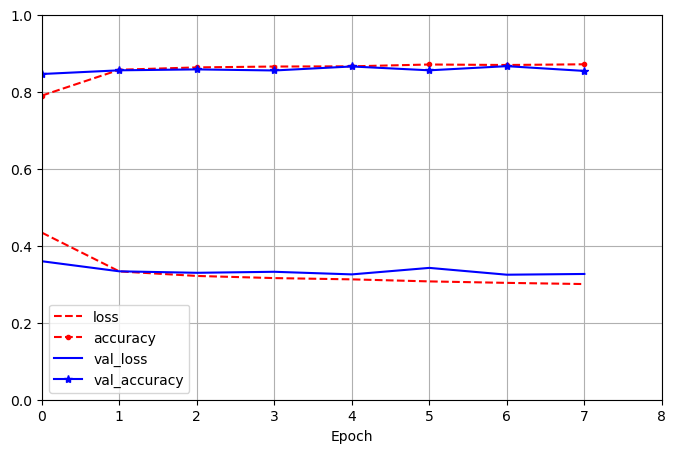

In [13]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 8], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")
plt.show()